<h5><b>Reading Data</b></h5>

In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Call_Details.csv")

In [3]:
df.head()

,datetime,calls
0,2015-01-01 00:00:00,20.0
1,2015-01-01 01:00:00,10.0
2,2015-01-01 02:00:00,2.0
3,2015-01-01 03:00:00,4.0
4,2015-01-01 04:00:00,1.0


In [4]:
df.tail()

,datetime,calls
24924,2017-12-31 19:00:00,186.0
24925,2017-12-31 20:00:00,104.0
24926,2017-12-31 21:00:00,55.0
24927,2017-12-31 22:00:00,41.0
24928,2017-12-31 23:00:00,40.0


In [5]:
df.shape

(24929, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24929 entries, 0 to 24928
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  24929 non-null  object 
 1   calls     24929 non-null  float64
dtypes: float64(1), object(1)
memory usage: 389.6+ KB


In [7]:
df.isnull().sum()

datetime    0
calls       0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24929 entries, 0 to 24928
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  24929 non-null  datetime64[ns]
 1   calls     24929 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 389.6 KB


In [11]:
# Creating new DataFrame with hourly frequency and number of calls
df_agg = df.groupby(pd.Grouper(key='datetime', freq='H'))['calls'].sum().reset_index()
df_agg.set_index('datetime', inplace=True)
df_agg.index.freq = 'H' 

<h5><b>EDA</b></h5>

In [12]:
# Resample the data to monthly frequency and aggregate the calls
df_monthly = df_agg['calls'].resample('M').sum()

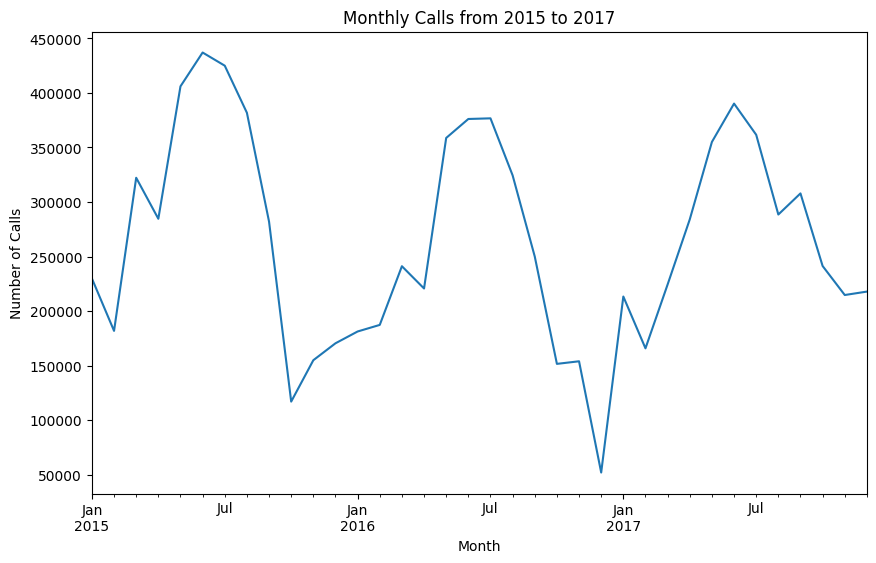

In [13]:
# Plot the monthly data
plt.figure(figsize=(10, 6))
df_monthly.plot()
plt.title('Monthly Calls from 2015 to 2017')
plt.xlabel('Month')
plt.ylabel('Number of Calls')
plt.show()

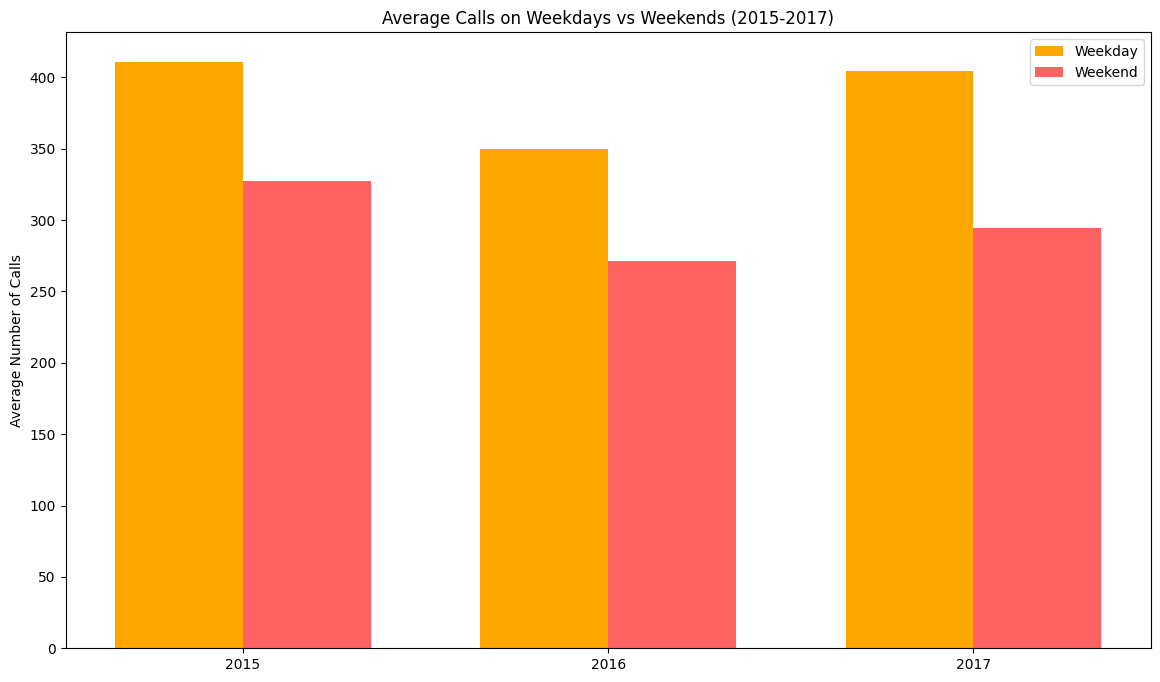

Weekday Statistics for 2015:
 count    6264.000000
mean      411.078704
std       367.280166
min         0.000000
25%        62.000000
50%       347.000000
75%       678.250000
max      2341.000000
Name: calls, dtype: float64

Weekend Statistics for 2015:
 count    2496.000000
mean      327.553285
std       326.727468
min         0.000000
25%        60.750000
50%       257.000000
75%       481.000000
max      2044.000000
Name: calls, dtype: float64
--------------------------------------------------
Weekday Statistics for 2016:
 count    6264.000000
mean      349.547254
std       329.025013
min         0.000000
25%        42.000000
50%       282.000000
75%       577.000000
max      2030.000000
Name: calls, dtype: float64

Weekend Statistics for 2016:
 count    2520.000000
mean      271.524206
std       267.112080
min         0.000000
25%        39.000000
50%       220.000000
75%       413.000000
max      1549.000000
Name: calls, dtype: float64
-------------------------------------------

In [14]:
# Function to perform EDA for specific years
def eda_weekday_weekend_by_year(df, years):
    plt.figure(figsize=(14, 8))
    
    width = 0.35  # Width of the bars
    positions = np.arange(len(years))  # Positions for each year

    for i, year in enumerate(years):
        # Filter data for the specific year
        df_year = df[df.index.year == year].copy()  # Make a copy to avoid SettingWithCopyWarning
        
        # Add a column to identify Weekday or Weekend
        df_year.loc[:, 'day_type'] = np.where(df_year.index.dayofweek >= 5, 'Weekend', 'Weekday')
        
        # Group by 'day_type' and calculate statistics
        weekday_data = df_year[df_year['day_type'] == 'Weekday']
        weekend_data = df_year[df_year['day_type'] == 'Weekend']
        
        # Calculate average calls
        weekday_mean = weekday_data['calls'].mean()
        weekend_mean = weekend_data['calls'].mean()
        
        # Plotting
        plt.bar(positions[i] - width/2, weekday_mean, width, color='#ffa600')
        plt.bar(positions[i] + width/2, weekend_mean, width, color='#ff6361')
    
    # Add legend only once, after plotting all bars
    plt.legend(['Weekday', 'Weekend'], loc='upper right')
    plt.title('Average Calls on Weekdays vs Weekends (2015-2017)')
    plt.ylabel('Average Number of Calls')
    plt.xticks(positions, [f'{year}' for year in years])
    plt.show()

    # Additional statistics for each year
    for year in years:
        df_year = df[df.index.year == year].copy()
        df_year.loc[:, 'day_type'] = np.where(df_year.index.dayofweek >= 5, 'Weekend', 'Weekday')
        
        weekday_data = df_year[df_year['day_type'] == 'Weekday']
        weekend_data = df_year[df_year['day_type'] == 'Weekend']
        
        weekday_stats = weekday_data['calls'].describe()
        weekend_stats = weekend_data['calls'].describe()
        
        print(f"Weekday Statistics for {year}:\n", weekday_stats)
        print(f"\nWeekend Statistics for {year}:\n", weekend_stats)
        print("-" * 50)

# Perform EDA for each year
eda_weekday_weekend_by_year(df_agg, [2015, 2016, 2017])

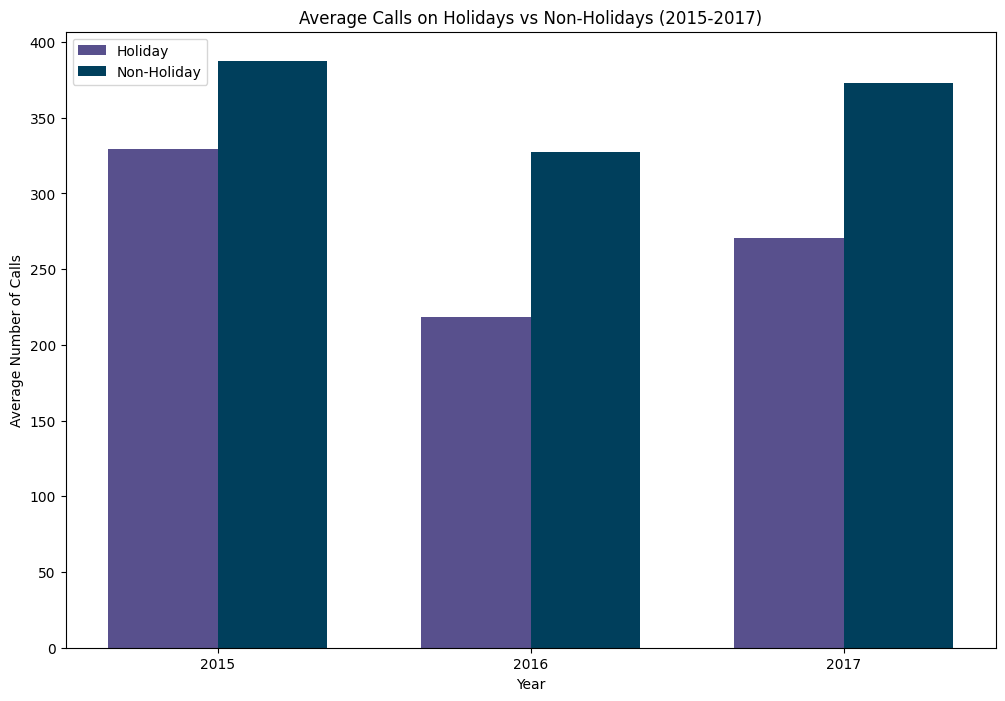

In [15]:
import holidays

# Define a function to get holidays for Delhi
def get_delhi_holidays(year):
    # Create a holiday object for Delhi (state code 'DL')
    delhi_holidays = holidays.India(years=[year], observed=True)
    return pd.to_datetime(list(delhi_holidays.keys()), format='%Y-%m-%d')

# Function to perform EDA for holidays and non-holidays for a specific year
def eda_holiday_nonholiday_by_year(df, years):
    holiday_means = []
    nonholiday_means = []
    year_labels = []
    
    for year in years:
        # Filter data for the specific year
        df_year = df[df.index.year == year].copy()  # Use .copy() to avoid the SettingWithCopyWarning
        
        # Get holidays for Delhi for the specific year
        holiday_dates = get_delhi_holidays(year)
        
        # Add a column to identify Holiday or Non-Holiday
        df_year.loc[:, 'is_holiday'] = df_year.index.isin(holiday_dates)  # Use .loc to avoid the warning
        
        # Group by 'is_holiday' and calculate statistics
        holiday_data = df_year[df_year['is_holiday']]
        nonholiday_data = df_year[~df_year['is_holiday']]
        
        # Calculate means
        holiday_mean = holiday_data['calls'].mean()
        nonholiday_mean = nonholiday_data['calls'].mean()
        
        # Store the results
        holiday_means.append(holiday_mean)
        nonholiday_means.append(nonholiday_mean)
        year_labels.append(year)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    
    x = range(len(years))
    width = 0.35  # the width of the bars
    
    plt.bar(x, holiday_means, width=width, label='Holiday', color='#58508d')
    plt.bar([p + width for p in x], nonholiday_means, width=width, label='Non-Holiday', color='#003f5c')
    
    plt.xlabel('Year')
    plt.ylabel('Average Number of Calls')
    plt.title('Average Calls on Holidays vs Non-Holidays (2015-2017)')
    
    # Add labels and ticks
    plt.xticks([p + width/2 for p in x], year_labels)
    plt.legend()
    plt.show()

# Perform EDA for the years 2015, 2016, and 2017
eda_holiday_nonholiday_by_year(df_agg, [2015, 2016, 2017])


<h5><b>Seasonal Decomposition</b></h5>

In [16]:
# importing time series stats model
import statsmodels.api as sm
from statsmodels.api import tsa 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [17]:
# decompose the time series
decomposition = tsa.seasonal_decompose(df_agg['calls'], model='additive')

In [18]:
hourly_df = df_agg.copy()

In [19]:
hourly_df['Trend'] = decomposition.trend
hourly_df['Seasonal'] = decomposition.seasonal
hourly_df['Residual'] = decomposition.resid

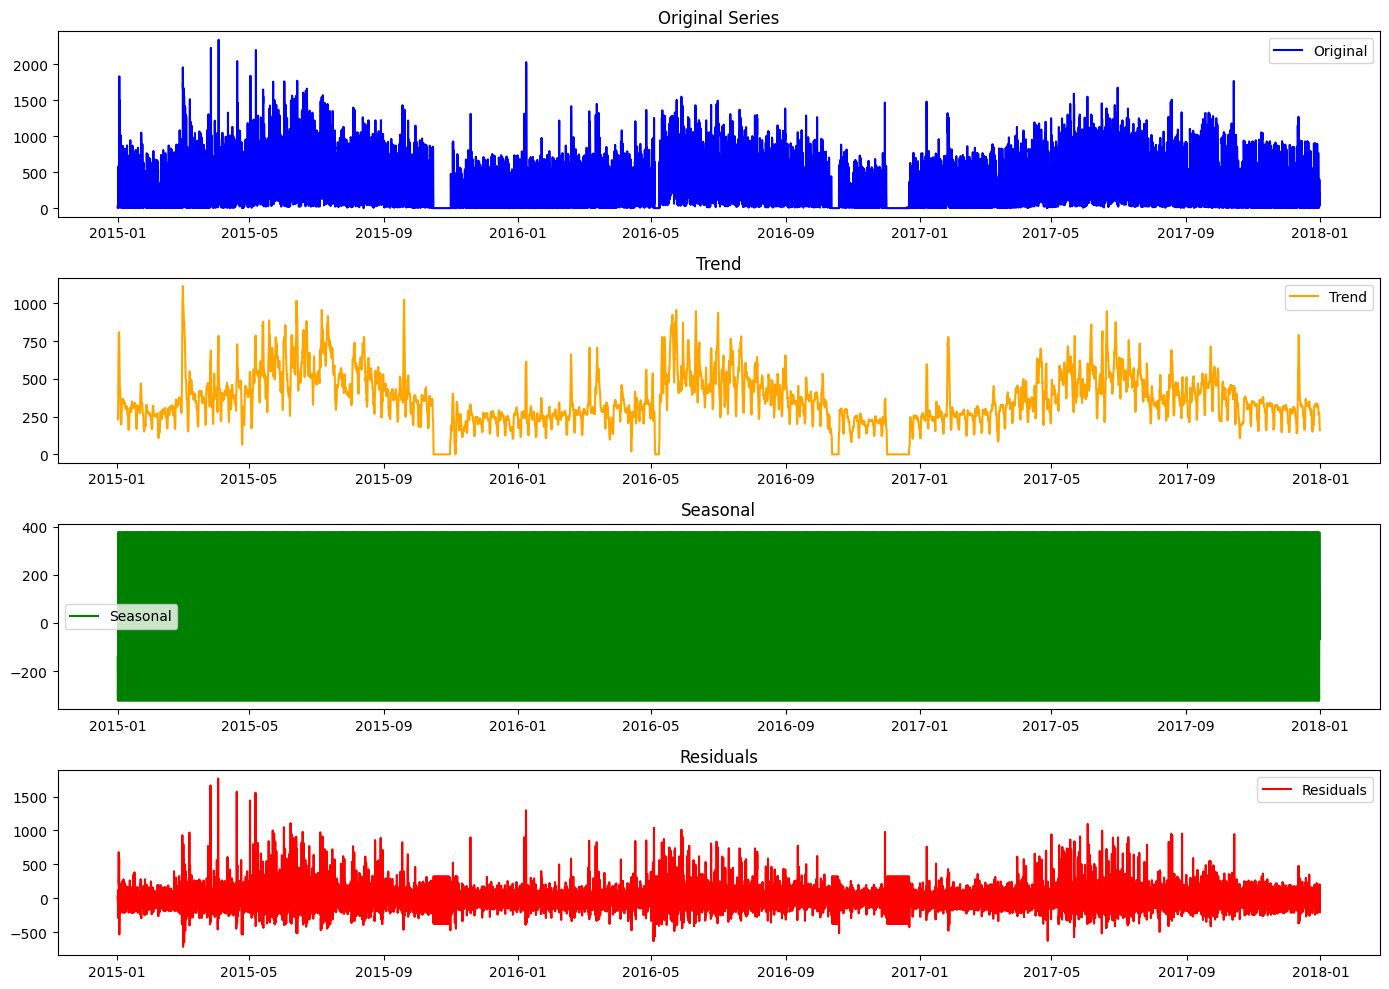

In [20]:
plt.figure(figsize=(14, 10))

# Plot Original Series
plt.subplot(4, 1, 1)
plt.plot(hourly_df.index, hourly_df['calls'], label='Original', color='blue')
plt.title('Original Series')
plt.legend(loc='best')

# Plot Trend
plt.subplot(4, 1, 2)
plt.plot(hourly_df.index, hourly_df['Trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend(loc='best')

# Plot Seasonal
plt.subplot(4, 1, 3)
plt.plot(hourly_df.index, hourly_df['Seasonal'], label='Seasonal', color='green')
plt.title('Seasonal')
plt.legend(loc='best')

# Plot Residuals
plt.subplot(4, 1, 4)
plt.plot(hourly_df.index, hourly_df['Residual'], label='Residuals', color='red')
plt.title('Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

<h5><b>Checking stationarity</b></h5>

In [21]:
def perform_adf_test(df) -> None:
    """
    Augmented Dickey Fuller Test
    - The null hypothesis for this test is that there is a unit root.
    - The alternate hypothesis is that there is no unit root in the series.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data
        
    Returns: None
    """
    
    adf_stat, p_value, n_lags, n_observ, crit_vals, icbest = adfuller(df)
    
    print('\nAugmented Dickey Fuller Test')
    print('---'*15)
    print('ADF Statistic: %f' % adf_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Number of observations used: {n_observ}')
    print(f'T values corresponding to adfuller test:')
    for key, value in crit_vals.items():
        print(key, value)


def perform_kpss_test(df) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        
    Returns: None
    """
    
    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)

In [22]:
print("ADF and KPSS test on original total_amount")
print("******************************************")
perform_adf_test(hourly_df['calls'])
perform_kpss_test(hourly_df['calls'])

ADF and KPSS test on original total_amount
******************************************

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -9.905122
p-value: 0.000000
Number of lags used: 49
Number of observations used: 26254
T values corresponding to adfuller test:
1% -3.430599102593299
5% -2.8616500960359854
10% -2.5668286008605627

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 1.478641
p-value: 0.010000
Number of lags used: 56
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


c:\Users\ANKUSH\anaconda3\envs\prpht\lib\site-packages\statsmodels\tsa\stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [23]:
#differencing with previous day
hourly_df["day_difference"] = hourly_df["calls"].diff(1)

In [24]:
print("  ADF and KPSS test on differnced data  ")
print("******************************************")
perform_adf_test(hourly_df["day_difference"].dropna())
perform_kpss_test(hourly_df["day_difference"].dropna())

  ADF and KPSS test on differnced data  
******************************************

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -35.446586
p-value: 0.000000
Number of lags used: 49
Number of observations used: 26253
T values corresponding to adfuller test:
1% -3.4305991120827652
5% -2.861650100229875
10% -2.5668286030928766

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.009576
p-value: 0.100000
Number of lags used: 296
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


c:\Users\ANKUSH\anaconda3\envs\prpht\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [25]:
def train_test_split(df, train_end, test_set):
    """
    Splits input dataframe into test and train set with 80% / 20%.
    ---
    Args:
        df : dataframe to split with datetime index.
        train_end: end date of the train set (inclusive), it can be a datetime or string of format YYYY-MM-DD.
        test_end: end date of the test set

    Returns:
        train_df (pd.DataFrame): Train Dataframe
        test_df (pd.DataFrame):  Test Dataframe
    """
    train_set = df[df.index <= train_end]
    test_set = df[df.index > train_end]
    return train_set, test_set


train_end = '2016-12-31 23:00'
test_end = '2017-12-31'

train_df, test_df = train_test_split(df_agg , train_end, test_end)

In [26]:
print(f'The Train data has time range :Shape {train_df.shape} | {train_df.index[0]} to {train_df.index[-1]}')
print(f'The Test data has time range :Shape {test_df.shape} | {test_df.index[0]} to {test_df.index[-1]}' )

The Train data has time range :Shape (17544, 1) | 2015-01-01 00:00:00 to 2016-12-31 23:00:00
The Test data has time range :Shape (8760, 1) | 2017-01-01 00:00:00 to 2017-12-31 23:00:00


In [27]:
def modified_mape_metrics(test_set: pd.Series, predicted: pd.Series, epsilon=1e-5, cap=100) -> float:
    """
    This function calculates the modified Mean Absolute Percentage Error (MAPE).
    ---
    Args:
        test_set (pd.Series): Test set filtered series with y (actual values)
        predicted (pd.Series): Predicted series
        epsilon (float): Small constant to avoid division by zero (default=1e-5)
        cap (float): Maximum percentage error to cap the loss (default=100)
        
    Returns: 
        float: Modified MAPE percentage
    """
    # Calculate the modified absolute percentage errors
    mape_values = np.abs(test_set - predicted) / np.maximum(np.abs(test_set), epsilon) * 100
    
    # Cap the MAPE values
    mape_values = np.minimum(mape_values, cap)
    
    # Calculate and return the mean of the modified percentage errors
    modified_mape_result = round(np.mean(mape_values), 2)
    
    return modified_mape_result


def rmse_metrics(test_set, predicted) -> float:
    """
    This function calculates the RMSE.
    ---
    Args:
        test_set (pd.Series):  test set filtered series with y
        predicted (pd.Series):  predicted series
        
    Returns: float RMSE
    """  
    # Calculate the MAPE value and return
    return round(np.sqrt(np.mean((test_set - predicted)**2)),2)

In [28]:
def plot_acf_pacf(df, acf_lags: int, pacf_lags: int) -> None:
    """
    This function plots the Autocorrelation and Partial Autocorrelation lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the order count and dates.
        acf_lags (int): Number of ACF lags
        pacf_lags (int): Number of PACF lags
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), facecolor='w')
    
    # ACF & PACF
    plot_acf(df, ax=ax1, lags=acf_lags)
    plot_pacf(df, ax=ax2, lags=pacf_lags, method='ywm')

    # Labels
    ax1.set_title(f"Autocorrelation {df.name}", fontsize=15, pad=10)
    ax1.set_ylabel("Sales amount", fontsize=12)
    ax1.set_xlabel("Lags (Days)", fontsize=12)

    ax2.set_title(f"Partial Autocorrelation {df.name}", fontsize=15, pad=10)
    ax2.set_ylabel("Sales amount", fontsize=12)
    ax2.set_xlabel("Lags (Days)", fontsize=12)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')

    plt.show()


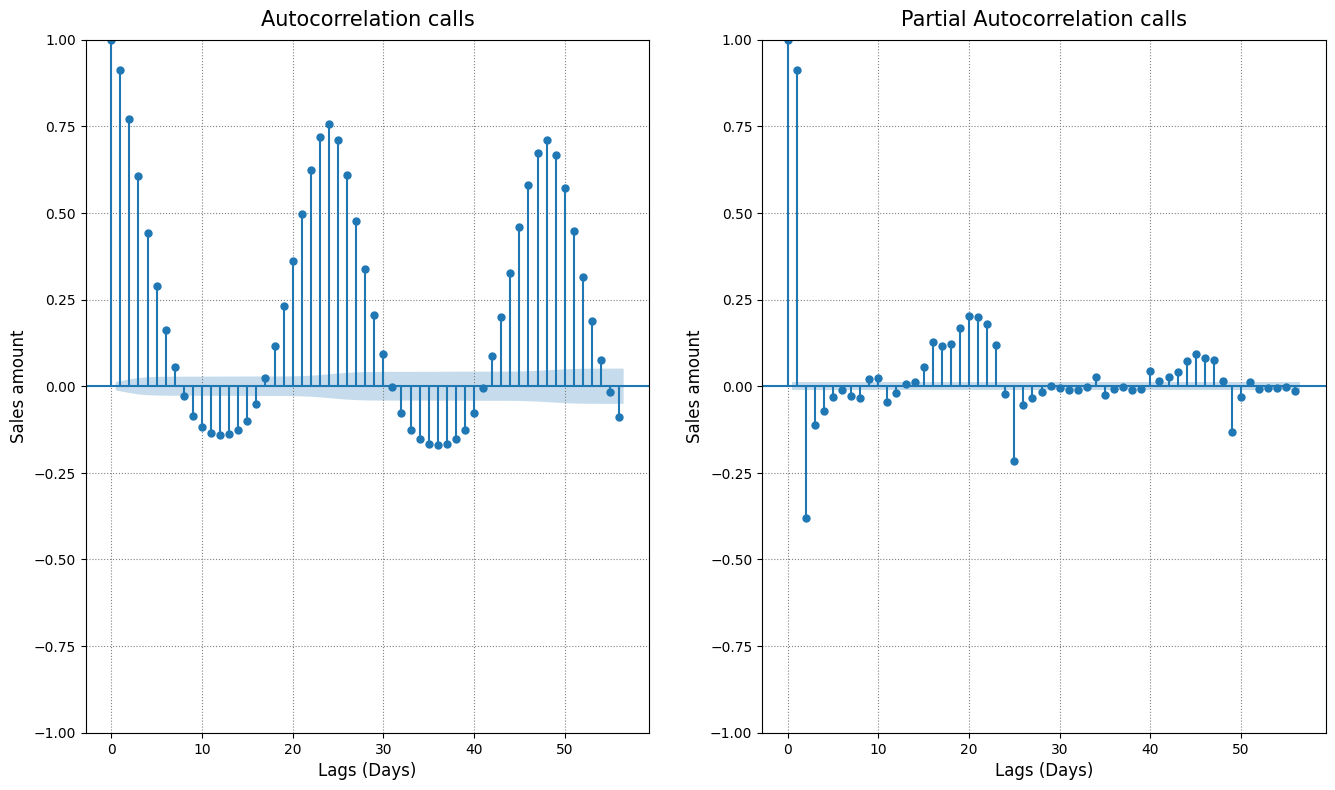

In [29]:
#plotting the ACF and PACF plot for original series
plot_acf_pacf(df_agg['calls'], acf_lags=56, pacf_lags= 56)

In [30]:
#importing Sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
# Set Hyper-parameters
p, d, q = 4, 1, 0
P, D, Q = 1, 1, 1
s = 24

# Fit SARIMA
sarima_model = SARIMAX(train_df['calls'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit(disp=0)
print(sarima_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                calls   No. Observations:                17544
Model:             SARIMAX(4, 1, 0)x(1, 1, [1], 24)   Log Likelihood             -106909.899
Date:                              Thu, 22 Aug 2024   AIC                         213833.797
Time:                                      12:22:08   BIC                         213888.195
Sample:                                  01-01-2015   HQIC                        213851.709
                                       - 12-31-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0182      0.003      6.562      0.000       0.013       0.024
ar.L2         -0.07

In [32]:
# defining prediction period
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarima_predictions = sarima_model_fit.predict(start=pred_start_date, end=pred_end_date)
sarima_residuals = test_df['calls'] - sarima_predictions

In [33]:
# Get evaluation data
sarima_root_mean_squared_error = rmse_metrics(test_df['calls'], sarima_predictions)
mape_error = modified_mape_metrics(test_df['calls'], sarima_predictions)

print(f'Root Mean Squared Error | RMSE: {sarima_root_mean_squared_error}')
print(f'Mean Absolute Percentage Error | MAPE: {mape_error}')

Root Mean Squared Error | RMSE: 504.11
Mean Absolute Percentage Error | MAPE: 68.67


<h5><b>SARIMAX using an Exogenous variable</b></h5>

In [34]:
dfex = pd.read_csv("weather_holidays_weekends.csv")

In [35]:
dfex.head()

,datetime,calls,temperature,humidity,windspeed,cloud,rainrate,is_weekend,is_holiday
0,01-01-2015 00:00,20,13.0,94.0,2.875,0.0,0.0,0,0
1,01-01-2015 01:00,10,13.0,94.0,2.875,0.0,0.0,0,0
2,01-01-2015 02:00,2,13.0,94.0,2.875,0.0,0.0,0,0
3,01-01-2015 03:00,4,13.0,94.0,2.875,0.0,0.0,0,0
4,01-01-2015 04:00,1,13.0,94.0,2.875,0.0,0.0,0,0


In [36]:
dfex.tail()

,datetime,calls,temperature,humidity,windspeed,cloud,rainrate,is_weekend,is_holiday
24518,31-12-2017 19:00,186,16.5,88.0,2.1,0.0,0.0,1,0
24519,31-12-2017 20:00,104,16.5,88.0,2.1,0.0,0.0,1,0
24520,31-12-2017 21:00,55,16.5,88.0,2.1,0.0,0.0,1,0
24521,31-12-2017 22:00,41,16.5,88.0,2.1,0.0,0.0,1,0
24522,31-12-2017 23:00,40,16.5,88.0,2.1,0.0,0.0,1,0


In [37]:
dfex.duplicated().sum()

0

In [38]:
dfex.isnull().sum()

datetime       0
calls          0
temperature    0
humidity       0
windspeed      0
cloud          0
rainrate       0
is_weekend     0
is_holiday     0
dtype: int64

In [39]:
dfex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24523 entries, 0 to 24522
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     24523 non-null  object 
 1   calls        24523 non-null  int64  
 2   temperature  24523 non-null  float64
 3   humidity     24523 non-null  float64
 4   windspeed    24523 non-null  float64
 5   cloud        24523 non-null  float64
 6   rainrate     24523 non-null  float64
 7   is_weekend   24523 non-null  int64  
 8   is_holiday   24523 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 1.7+ MB


In [40]:
dfex['datetime'] = pd.to_datetime(dfex['datetime'],format = "%d-%m-%Y %H:%M")

In [41]:
# Creating new DataFrame with hourly frequency and number of calls
dfex_agg = dfex.groupby(pd.Grouper(key='datetime', freq='H'))[['calls', 'temperature', 'humidity', 'windspeed', 'cloud', 'rainrate','is_weekend','is_holiday']].sum().reset_index()
dfex_agg.set_index('datetime', inplace=True)
dfex_agg.index.freq = 'H'

In [42]:
#splitting into test and train
train_dfex, test_dfex = train_test_split(dfex_agg, train_end, test_end)

In [43]:
train_dfex.head()

,calls,temperature,humidity,windspeed,cloud,rainrate,is_weekend,is_holiday
datetime,,,,,,,,
2015-01-01 00:00:00,20,13.0,94.0,2.875,0.0,0.0,0,0
2015-01-01 01:00:00,10,13.0,94.0,2.875,0.0,0.0,0,0
2015-01-01 02:00:00,2,13.0,94.0,2.875,0.0,0.0,0,0
2015-01-01 03:00:00,4,13.0,94.0,2.875,0.0,0.0,0,0
2015-01-01 04:00:00,1,13.0,94.0,2.875,0.0,0.0,0,0


In [44]:
# Set Hyper-parameters
p, d, q = 2, 1, 2
P, D, Q = 0, 1, 1
s = 24

# Fit SARIMA
sarimax_model = SARIMAX(train_dfex['calls'], 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, s), 
                       exog=(train_dfex[['temperature','humidity','windspeed','cloud','rainrate','is_weekend','is_holiday']]))
sarimax_model_fit = sarimax_model.fit(disp=0)
print(sarimax_model_fit.summary())

c:\Users\ANKUSH\anaconda3\envs\prpht\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ANKUSH\anaconda3\envs\prpht\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                calls   No. Observations:                17544
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 24)   Log Likelihood             -106459.170
Date:                              Thu, 22 Aug 2024   AIC                         212944.341
Time:                                      12:33:27   BIC                         213045.364
Sample:                                  01-01-2015   HQIC                        212977.606
                                       - 12-31-2016                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    10.8980      0.269     40.475      0.000      10.370      11.426
humidity       -

In [45]:
pred_start_date = pd.to_datetime(test_dfex.index[0])
pred_end_date = pd.to_datetime(test_dfex.index[-1])

sarimax_predictions = sarimax_model_fit.predict(
    start=pred_start_date,
    end=pred_end_date,
    exog=test_dfex[['temperature', 'humidity', 'windspeed', 'cloud', 'rainrate','is_weekend','is_holiday']]
)


In [46]:
sarimax_root_mean_squared_error = rmse_metrics(test_dfex['calls'], sarimax_predictions)
sarimax_mape=modified_mape_metrics(test_dfex['calls'], sarimax_predictions)

print(f'Root Mean Squared Error | RMSE: {sarimax_root_mean_squared_error}')
print(f'Mean Absolute Percentage Error | MAPE: {sarimax_mape}')

Root Mean Squared Error | RMSE: 299.48
Mean Absolute Percentage Error | MAPE: 58.79


<h5><b>LSTM Modelling</b></h5>

In [47]:
from sklearn.preprocessing import MinMaxScaler

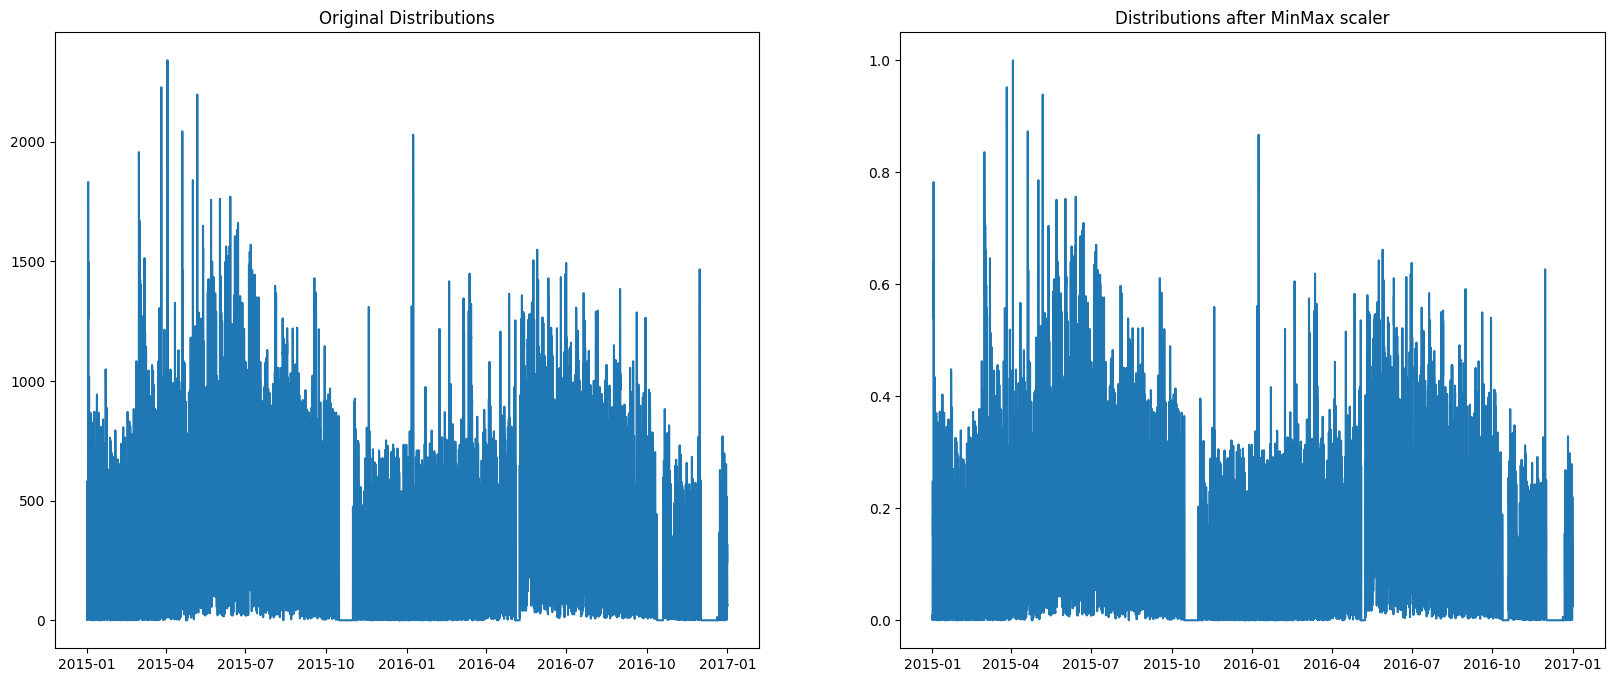

In [48]:
#scaling the date
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(train_df)
test_scaled = sc.transform(test_df)
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax0.set_title('Original Distributions')
ax1.set_title('Distributions after MinMax scaler')
ax0.plot(train_df['calls'])
ax1.plot(pd.DataFrame(training_scaled,columns=['calls'], index=train_df.index)['calls'])

In [49]:
#define the lookback function for creating y

def lookback(df, window):
    X = list()
    Y = list()

    for i in range(window,len(df)):
        X.append(df[i-window:i, 0])
        Y.append(df[i,0])
    
    X,Y = np.array(X),np.array(Y)
    return X, Y

In [50]:
#creating X and y using lookback function
X_train_lstm, y_train_lstm = lookback(training_scaled, 1)
X_test_lstm, y_test_lstm = lookback(test_scaled, 1)

In [51]:
#checking shape of X
X_train_lstm.shape

(17543, 1)

In [33]:
#reshaping X for LSTM
#number of observations, timesteps and features
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0],X_train_lstm.shape[1],1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0],X_test_lstm.shape[1],1))

In [34]:
X_train_lstm.shape

(17543, 1, 1)

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [38]:
# random seeds for reproducibility
np.random.seed(2314)
tf.random.set_seed(2314)

model = Sequential()
# The input of LSTM layer has a shape of (num_timesteps, num_features)
model.add(LSTM(100, return_sequences=True, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu' ))
model.add(Dropout(0.2))
          
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, shuffle=False,
                    validation_data=(X_test_lstm, y_test_lstm), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1097/1097 [==============================

In [37]:
#calaculating predictions
prediction_lstm = model.predict(X_test_lstm)

274/274 [==============================] - 3s 2ms/step


In [38]:
#predicting and inversing the predictions to original time scale.

prediction_inverse = sc.inverse_transform(prediction_lstm.reshape(-1, 1))
y_test_inverse = sc.inverse_transform(y_test_lstm.reshape(-1, 1))

prediction2_inverse = np.array(prediction_inverse[:,0][1:])
y_test2_inverse = np.array(y_test_inverse[:,0])

In [39]:
#Evaluating the LSTM model.

y_test2_inverse_without_last = y_test2_inverse[:-1]
rmse_lstm = rmse_metrics(y_test2_inverse_without_last, prediction2_inverse)
mape_lstm = modified_mape_metrics(y_test2_inverse_without_last, prediction2_inverse)
print(f"Root Mean Squared Error | RMSE: {rmse_lstm}")
print(f"Mean Absolute Percentage Error | MAPE: {mape_lstm}")

Root Mean Squared Error | RMSE: 52.12
Mean Absolute Percentage Error | MAPE: 21.67


In [36]:
model =tf.keras.models.load_model("call_vol_pred.h5")

In [43]:
datetime_index = pd.to_datetime(test_df.index[-len(y_test_inverse):])

# Create a DataFrame
results_df = pd.DataFrame({
    'datetime': datetime_index,
    'actual': y_test_inverse[:, 0],
    'predicted': prediction_inverse[:, 0]
})

In [46]:
results_df.head()

,datetime,actual,predicted
0,2017-01-01 01:00:00,17,35
1,2017-01-01 02:00:00,12,31
2,2017-01-01 03:00:00,3,27
3,2017-01-01 04:00:00,7,22
4,2017-01-01 05:00:00,12,24


In [47]:
results_df.tail()

,datetime,actual,predicted
8754,2017-12-31 19:00:00,186,227
8755,2017-12-31 20:00:00,104,201
8756,2017-12-31 21:00:00,55,118
8757,2017-12-31 22:00:00,41,66
8758,2017-12-31 23:00:00,40,52


In [44]:
# Convert decimal values to integers
results_df['actual'] = results_df['actual'].astype(int)
results_df['predicted'] = results_df['predicted'].astype(int)

In [48]:
# Save DataFrame to CSV
results_df.to_csv('results.csv', index=False)

Here is the summary of all the models we tested:
    
 ### Summary:

|Model|MAPE|
|----|----|
|SARIMA(4,1,0)(1,1,1)(24)|68.67 |
|SARIMAX(2,1,2)(0,1,1)(24) Including Exogenous variables|58.79|
|LSTM| 21.67 | 

**We will be choosing the LSTM as the best performing model because it is able to achieve considerable MAPE.** 